# SWMM with Python Week 3: Sensitivity Analysis Part 2

Sensitivity analysis is such a big word, I used to say it just to sound smart. 

As I am getting better at modeling I started to appreciate the benefits of doing sensitivity analysis. The most useful form of sensitivity analysis is the casual ones every modeler does on a daily basis, "give it a try and see what happens.", "try a few combinations of the parameters and see what happens."

So you got the idea, at the heart of how we learn something, it is sensitivty analysis. And we are all experts of doing it without even thinking about it.

The challenge when working with swmm models is that the number of factors we need to keep track is way beyond what we can easily remember, so taking a systamatic approach will not only save us time, but also help us learn faster.

Python is a great, with the right libraries I can cut through the tedious part of the learning process, and this week I'll show you how it can be a time saver when doing sensitivity analysis.

Below is the function that can render a new input file from a dictionary. 

In [3]:
from jinja2 import Environment, FileSystemLoader
import logging

def render_input(tmp_folder,tmp_name,  data, out_inp):
    '''
    render an input file using a template.
    tmp_folder: folde where the template inp file is.
    tmp_name: name of the template file
    data: the data to be applied to the template
    out_inp: the inp file with values applied
    '''
    env = Environment(loader=FileSystemLoader(tmp_folder))
    template = env.get_template(tmp_name)
    output_from_parsed_template = template.render(data)
    # to save the results
    with open(out_inp, "w") as fh:
        fh.write(output_from_parsed_template)
        logging.info('inp created:%s' % out_inp)

from pyswmm import Simulation, Subcatchments
import matplotlib.pyplot as plt
def run(inp_path):
    sim = Simulation(inp_path)
    sim.execute()


from swmm.output import output as smo
import pandas as pd
import datetime

def swmm_dt(days):
    # convert swmm dates number to date
    # https://www.openswmm.org/Topic/4343/output-file-start-date-and-time-of-the-simulation
    t0 = pd.to_datetime('12/31/1899 00:00')
    t1 = t0 + datetime.timedelta(days=(days-1)) # I don't understand why I need to -1, hey it works. 
    return t1


def extract_rainfall(out_path, sub_index=0):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 0))

    # get the time sereis from the out file
    values = smo.getsubcatchseries(handle, 0, smo.SubcatchAttribute.RAINFALL, 0, num_steps)
    df = pd.DataFrame({'rainfall': values}, index=timestep)
    return df

def extract_infiltration(out_path, sub_index=0):
    # extract the rainfall results from *.out file
    handle = smo.init()
    smo.open(handle, out_path)

    # swmm out file report time using its only integer format, it needs to be converted to datetime
    report_start_date_time = smo.getstartdate(handle)
    start_dt = swmm_dt(report_start_date_time)

    # to build the timestamps, we'll need the number of reported steps, and the step length in seconds
    num_steps = smo.gettimes(handle, smo.Time.NUM_PERIODS)
    report_step = smo.gettimes(handle, smo.Time.REPORT_STEP)

    # build the date range
    timestep = pd.date_range(start=start_dt, periods=num_steps, freq='%smin' % (report_step/60.0))


    # Just want to confirm the subcatchments index 
    print(smo.getelementname(handle, smo.ElementType.SUBCATCH, 0))

    # get the time sereis from the out file
    values = smo.getsubcatchseries(handle, 0, smo.SubcatchAttribute.INFIL_LOSS, 0, num_steps)
    df = pd.DataFrame({'infil': values}, index=timestep)
    return df

import os

def sensitivity_analysis(tmp_folder, tmp_name, out_folder, suction_list, k_list, imd_list):
    labels = ['l', 'm', 'h']

    dfs = None
    i = 0
    for sl, s in zip(labels, suction_list):
        for kl, k in zip(labels, k_list):
            for imdl, imd in zip(labels, imd_list):
                data = {'suction': s, 'ksat': k, 'imd': imd}
                run_id = '%s_%s_%s' % (sl, kl, imdl)
                out_inp = os.path.join(out_folder, '%s.inp' % run_id)
                out_path = os.path.join(out_folder, '%s.out' % run_id)
                print(out_inp)
                render_input(tmp_folder,tmp_name,  data, out_inp)
                run(out_inp)
                i += 1
                if i == 1:
                    df = extract_rainfall(out_path, 0)
                    dfs = df.copy()

                df = extract_infiltration(out_path, 0)
                dfs[run_id] = df['infil']
    return dfs

C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_l_l.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_l_m.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_l_h.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_m_l.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_m_m.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_m_h.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\l_h_l.inp

... SWMM Version 5.3.0.dev0
.

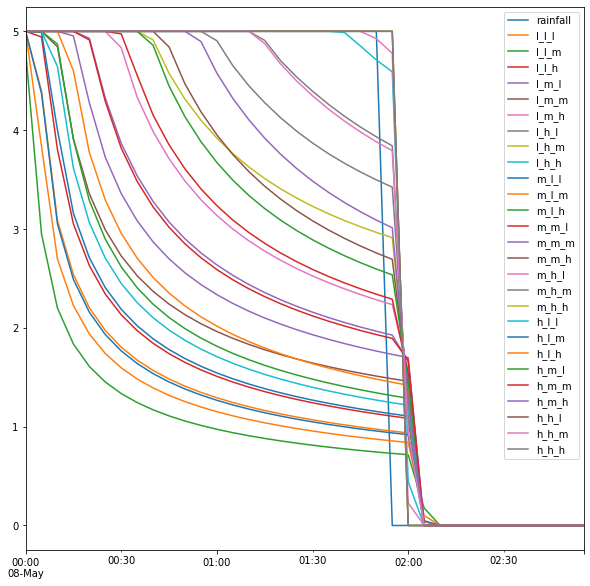

,rainfall,l_l_l,l_l_m,l_l_h,l_m_l,l_m_m,l_m_h,l_h_l,l_h_m,l_h_h,...,m_h_h,h_l_l,h_l_m,h_l_h,h_m_l,h_m_m,h_m_h,h_h_l,h_h_m,h_h_h
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,...,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,3.194444,1.184386,0.907702,1.363595,2.139057,1.689938,2.403036,3.185234,2.753516,3.321765,...,3.333333,1.526703,1.166454,1.755537,2.632709,2.116243,2.912868,3.333333,3.174835,3.333333
std,2.435681,1.177646,0.957458,1.305705,1.728748,1.472166,1.866713,2.258205,2.022496,2.358246,...,2.390457,1.415580,1.169309,1.550713,1.983007,1.720267,2.118118,2.390457,2.252210,2.390457
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,5.000000,1.083400,0.822636,1.258520,2.188191,1.664173,2.562317,4.466072,3.271322,5.000000,...,5.000000,1.417785,1.062366,1.661021,2.937545,2.149802,3.548372,5.000000,4.422939,5.000000
75%,5.000000,1.503884,1.124272,1.764466,3.122656,2.272203,3.779975,5.000000,4.658948,5.000000,...,5.000000,2.008532,1.473261,2.391209,4.549179,3.068706,5.000000,5.000000,5.000000,5.000000
max,5.000000,5.000000,4.808551,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000


In [7]:
tmp_folder = r"C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\tmp"
tmp_name = 'green_ampt_tmp.inp'
out_folder = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out'
suction_list = [2.4, 3.5, 4.3]
k_list = [0.13,0.43, 1.18]
imd_list = [8.5,4.7, 11.6]
dfs = sensitivity_analysis(tmp_folder, tmp_name, out_folder, suction_list, k_list, imd_list)
dfs.plot(figsize=(10, 10))
plt.show()
dfs.describe()

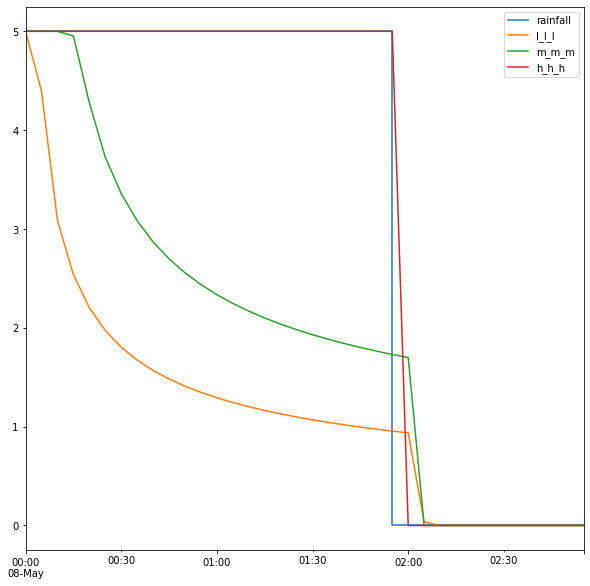

In [8]:
sub_dfs = dfs.loc[:, ['l_l_l', 'm_m_m', 'h_h_h', 'rainfall']]
rainfall = sub_dfs['rainfall']
del sub_dfs['rainfall']
ax = rainfall.plot(drawstyle="steps-post", label='rainfall')
sub_dfs.plot(ax=ax, figsize=(10,10))
plt.legend()

As shown above, changing the routing time step from 30 sec to 4 min showed the same results. So we know the routing time step probably doesn't have any impact on RTK hydrology without knowing anything about how it is implemented in SWMM. And this is a great news for modelers, many times, you don't need to know how things work internally to get some idea how they work. And that's the power of sensitivity analysis.

So if routing time step is not used for RTK hydrology calculation, then at what time step does RTK calculates the flow? It might be the time step of the rainfall data, so let's run some analysis of different rainfall time steps.

# Rainfall Data

So in this model we have a constant 1 in/hr rainfall lasted for 1hr at the beginning of the model, and we can represented as many forms,

- at 1hr time step
```
[TIMESERIES]
;;Name           Date       Time       Value     
;;-------------- ---------- ---------- ----------
rg_a                        00:00      1         
rg_a                        01:00      0     
```
- at 30 min step, we'll have 
```
[TIMESERIES]
;;Name           Date       Time       Value     
;;-------------- ---------- ---------- ----------
rg_a                        00:00      1         
rg_a                        00:30      1
rg_a                        01:00      0

```

I don't know why the results look the same, they should look different. I believe RTK uses rainfall time step to calculate the values, and thus the smaller rainfall time step should give a higher value. Because it is a different kind of unit hydrograph.

C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\0100.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
3
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\0030.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
3
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\0015.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
3
C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\0005.inp

... SWMM Version 5.3.0.dev0
... Run Complete1
3


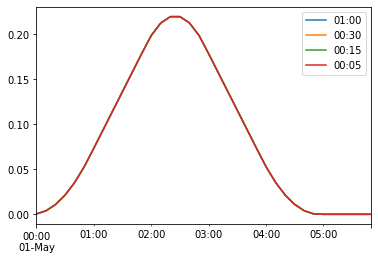

           01:00      00:30      00:15      00:05
count  36.000000  36.000000  36.000000  36.000000
mean    0.084031   0.084031   0.084031   0.084031
std     0.080569   0.080569   0.080569   0.080569
min     0.000000   0.000000   0.000000   0.000000
25%     0.003939   0.003939   0.003939   0.003939
50%     0.063242   0.063242   0.063242   0.063242
75%     0.157558   0.157558   0.157558   0.157558
max     0.219706   0.219706   0.219706   0.219706


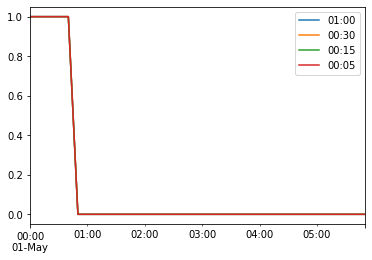

           01:00      00:30      00:15      00:05
count  36.000000  36.000000  36.000000  36.000000
mean    0.138889   0.138889   0.138889   0.138889
std     0.350736   0.350736   0.350736   0.350736
min     0.000000   0.000000   0.000000   0.000000
25%     0.000000   0.000000   0.000000   0.000000
50%     0.000000   0.000000   0.000000   0.000000
75%     0.000000   0.000000   0.000000   0.000000
max     1.000000   1.000000   1.000000   1.000000


In [5]:
rainfall_1hr = [['00:00', 1],
               ['01:00', 0]]

rainfall_30min = [['00:00', 1],
                   ['00:30', 1],
                  ['01:00', 0]]


rainfall_15min = [['00:00', 1],
                   ['00:15', 1],
                  ['00:30', 1],
                  ['00:45', 1],
                  ['01:00', 0]]


rainfall_5min = [['00:00', 1],
                   ['00:05', 1],
                  ['00:10', 1],
                 ['00:15', 1],
                 ['00:20', 1],
                 ['00:25', 1],
                  ['00:30', 1],
                 ['00:35', 1],
                 ['00:40', 1],
                 ['00:45', 1],
                 ['00:50', 1],
                 ['00:55', 1],
                  ['01:00', 0]]


tmp_folder = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\tmp'
tmp_name = 'rtk_with_rainfall.inp'
dfs = None
rainfalls = None
for rf_name, rainfall in zip(['01:00', '00:30', '00:15', '00:05'], [rainfall_1hr, rainfall_30min, rainfall_15min, rainfall_5min]):
    out_inp = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\%s.inp' % rf_name.replace(':', '')
    out_path = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\sensitivity_analysis\data\out\%s.out' % rf_name.replace(':', '')
    print(out_inp)
    data = {'lines': rainfall, 'interval': rf_name}
    render_input(tmp_folder,tmp_name,  data, out_inp)
    run(out_inp)
    df = extract_flow(out_path, node_index=0)
    if dfs is None:
        df[rf_name] = df['total_flow']
        dfs = df.loc[:, [rf_name]].copy()
        
    else:
        dfs[rf_name] = df['total_flow']
    
    df_rain = extract_rainfall(out_path)
    if rainfalls is None:
        df_rain[rf_name] = df_rain['rainfall']
        rainfalls = df_rain.loc[:, [rf_name]].copy()
    else:
        rainfalls[rf_name] = df_rain['rainfall']
        
        
dfs.plot()

plt.show()
print(dfs.describe())
    

rainfalls.plot()

plt.show()
print(rainfalls.describe())

1
1
1
1
1
1
1
1
1


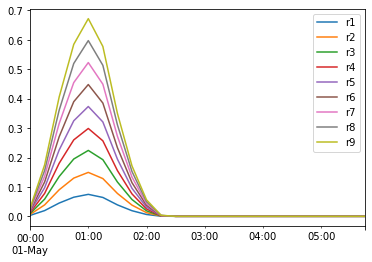

In [7]:
dfs = None
for i in range(1, 10):
    out_path = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\tmp\data\out\r%s.out' % i
    df = extract_flow(out_path, node_index=0)
    csv_path = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\tmp\data\out\r%s.csv' % i
#     df.to_csv(csv_path, index_label='datetime')
    
    
    if dfs is None:
        df['r%s' % i] = df['total_flow']
        dfs = df.loc[:, ['r%s' % i]].copy()
        
    else:
        dfs['r%s' % i] = df['total_flow']
    

dfs.plot()

plt.show()

In [8]:
dfs.max()

r1    0.074694
r2    0.149388
r3    0.224082
r4    0.298776
r5    0.373470
r6    0.448165
r7    0.522859
r8    0.597553
r9    0.672247
dtype: float64

In [4]:
dfs

In [5]:
_handle = smtk.alloc_project()
inp_name = r'C:\Users\Mel.Meng\Documents\GitHub\SewerAnalysis\examples\tmp\data\out\r1.inp'
smtk.run(_handle, inp_name, inp_name.replace('.inp', '.rpt'), inp_name.replace('.inp', '.out'))
smtk.free_project(_handle)

NameError: name 'smtk' is not defined



A model will never get tired when you are keep asking what if questions. And when it comes to learning, try something and see what happens is universal.

To me as a modeler, the most important thing when building a model is learning. Just like taking my driving road test, reading and watching everything I can find about the test will not get me pass it. I have to give it a try, more on the magnitude of thousands tries before I can pass it.

When working with a model, it is the same idea. I need to watch the model running hundreds of times before I can pass the test. And sensitivty analysis to a very large extent means the same thing. It is just a more systematic way of learning what parameters matters more for a model.

Before we can do sensitivity analysis, I need to figure out the following,
- change the parameter in the swmm model and run it in python
- run the models and compare the results

Let's get the programming part figured out first before we get deeper into sensitivity analysis.


## jinja2 templating

I've done some web development many years ago, and I used [jinja2](https://jinja.palletsprojects.com/en/2.11.x/) for rendering web pages using templates. And that works perfect for our purposes, when we change the parameters of a swmm input file, the rest stays the same and we only change a few values.

Say if I need to adjust the R1 values in my model, all I need to do is to replace the r1 value with {{ r1 }}, then I can pass the data {'r1': 0.5} to update the input file using a value of 0.5.

```
[HYDROGRAPHS]
;;Hydrograph     Rain Gage/Month  Response R        T        K        Dmax     Drecov   Dinit   
;;-------------- ---------------- -------- -------- -------- -------- -------- -------- --------
test             a               
test             All              Short    {{ r1 }}        0.5      2        0        0        0       
test             All              Medium   0        2        2        0        0        0       
test             All              Long     0        4        8        0        0        0       


```

And a more advanced example is that I can render an input file from a table. The following will render an input file of node coordinates from a table.

```python
data = [{'name': '1', 'x': 100, 'y': 100},
        {'name': '2', 'x': 200, 'y': 200},
        {'name': '3', 'x': 300, 'y': 300}]
```

```
[COORDINATES]
;;Node           X-Coord            Y-Coord           
;;-------------- ------------------ ------------------
{% for node in nodes %}
{{ node['name'] }}       {{ node['x'] }}      {{ node['y'] }}
{% endfor %}
```

